# Gamma-gamma model

Comparison with lifetimes

**Reference**:Fader, P. S., & Hardie, B. G. (2013). The Gamma-Gamma model of monetary value. February, 2, 1-9.

http://www.brucehardie.com/notes/025/gamma_gamma.pdf

In [1]:
import arviz as az
import matplotlib.pyplot as plt

In [2]:
from pymc_marketing import clv

In [3]:
# Extra dependency for this notebook
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter

## Load data

In [4]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

returning_customers_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


## Lifetimes implementation

In [5]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [6]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


In [7]:
avg_profit = ggf.conditional_expected_average_profit(
    summary_with_money_value['frequency'],
    summary_with_money_value['monetary_value']
)
avg_profit.head(10)

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64

In [8]:
avg_profit.mean()

35.25295817605007

## PyMC Marketing implementation

We can use the pre-built PyMC Marketing implementation of the Gamma-Gamma model, which also provides nice ploting and prediction methods

In [9]:
model = clv.GammaGammaModel(
    customer_id=returning_customers_summary.index,
    mean_transaction_value=returning_customers_summary["monetary_value"],
    frequency=returning_customers_summary["frequency"],
)

In [10]:
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [11]:
model.fit(fit_method="map").posterior.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (chain: 1, draw: 1)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0
Data variables:
    p        (chain, draw) float64 6.249
    q        (chain, draw) float64 3.745
    v        (chain, draw) float64 15.45
Attributes:
    created_at:                 2023-01-25T09:46:38.134606
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.0>

In [12]:
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Inference data with groups:
	> posterior
	> sample_stats

In [13]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.465,1.494,4.124,8.953,0.068,0.049,556.0,645.0,1.01
q,3.780,0.302,3.224,4.352,0.012,0.009,617.0,721.0,1.01
v,16.030,4.507,7.984,24.830,0.193,0.137,523.0,614.0,1.01


In [14]:
expected_spend = model.expected_customer_spend(
    customer_id=summary_with_money_value.index,
    mean_transaction_value=summary_with_money_value["monetary_value"],
    frequency=summary_with_money_value["frequency"],
)

In [15]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],24.697,0.536,23.792,25.831
x[2],18.969,1.390,16.529,21.763
x[3],35.180,0.909,33.480,36.858
x[4],35.180,0.909,33.480,36.858
x[5],35.180,0.909,33.480,36.858
x[6],71.388,0.642,70.187,72.592
x[7],18.969,1.390,16.529,21.763
x[8],35.180,0.909,33.480,36.858
x[9],27.310,0.409,26.559,28.120
x[10],35.180,0.909,33.480,36.858


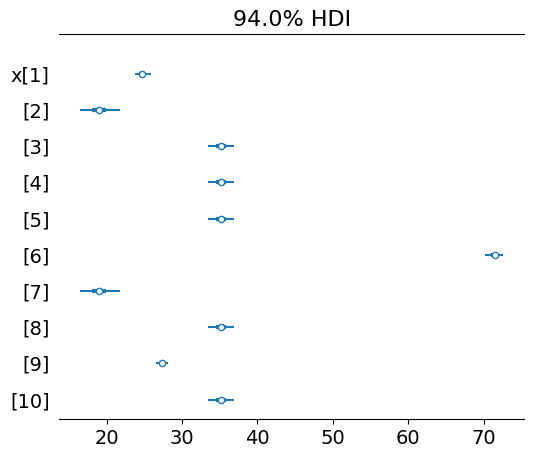

In [16]:
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True);

In [17]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,35.256,0.617,34.146,36.447


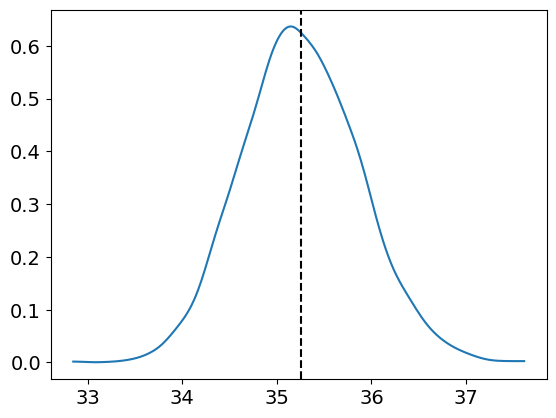

In [18]:
az.plot_dist(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--")